(In order to load the stylesheet of this notebook, execute the last code cell in this notebook)

# Yelp Reviews and Clustering

In this assignment, we will be working with the [Yelp dataset](http://cs-people.bu.edu/kzhao/teaching/yelp_dataset_challenge_academic_dataset.tar). You can find the format of the dataset [here](https://www.yelp.com/dataset_challenge).

First, we will look at Review Objects and perform some [sentiment analysis](http://sentiment.christopherpotts.net/) on the review text.

You will need to preprocess the text using a stemming algorithm. The Porter stemming algorithm is a well-known one. Then, use a lexicon to assign a score to a review based on the positive/negative words you find in the text. You can find various lexicons [here](http://sentiment.christopherpotts.net/lexicons.html).

After you have assigned scores to the reviews based on the text analysis, compare your scores with the stars associated with the reviews. **(20 pts)**

In [ ]:
from nltk import PorterStemmer
import string
import json
import time

filename = 'yelp_dataset_challenge_academic_dataset/yelp_academic_dataset_review.json'
    
def load_lexicon():
    data = dict()
    pos = open('positive-words.txt', 'r').read()[1537:].split('\n')
    neg = open('negative-words.txt', 'r').read()[1541:].split('\n')
    for word in pos:
        data[PorterStemmer().stem(word)] = 1
    for word in neg:
        data[PorterStemmer().stem(word)] = -1
    return data

def score_text(text):
    cleaned = text.lower().translate(string.maketrans("",""), string.punctuation).split()
    stemmed = [PorterStemmer().stem(word) for word in cleaned] # stem each word
    score = 0
    for word in stemmed:
        if word in lex:
            score += lex[word]
    return score

t = time.clock()
lex = load_lexicon()
stars = []
scores = []
review = dict()
for line in open(filename, 'r'):
    review = json.loads(line) # load review from file
    stars.append(review['stars']) # store star rating
    scores.append(score_text(review['text'].encode('ascii', 'ignore'))) # score text and store result
print time.clock() - t

Visualization and short (detailed) analysis. **(10 pts)**

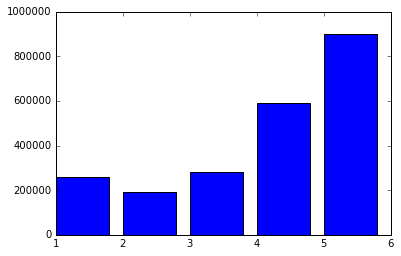

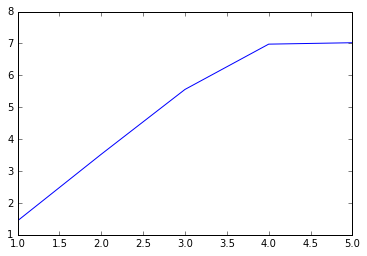

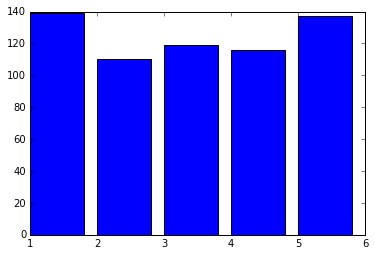

		Rating vs. Type of Response


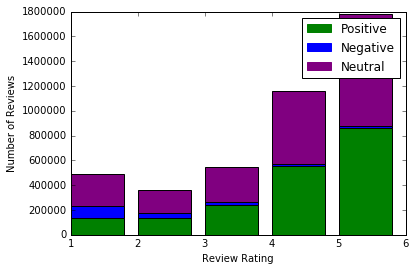

[{'avg': 1.4396948850636488, 'min': -72, 'max': 67, 'pos': 137576, 'neutral': 31232, 'neg': 91684, 'total': 260492}, {'avg': 3.526872158612561, 'min': -43, 'max': 67, 'pos': 135493, 'neutral': 17998, 'neg': 36557, 'total': 190048}, {'avg': 5.558945819967034, 'min': -30, 'max': 89, 'pos': 241378, 'neutral': 17971, 'neg': 22766, 'total': 282115}, {'avg': 6.979495214817669, 'min': -30, 'max': 86, 'pos': 553296, 'neutral': 20133, 'neg': 18189, 'total': 591618}, {'avg': 7.023837325460075, 'min': -47, 'max': 90, 'pos': 861501, 'neutral': 22581, 'neg': 16858, 'total': 900940}]


In [71]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

# FAKE DATA FOR TESTING

def bar(x, y):
    plt.bar(x, y)
    plt.show()
    
def multiple_bar(x, y_lst, labels, colors, title, xaxis, yaxis):
    delta = [0]*len(x)
    keys = []
    for i in range(len(y_lst)):
        for j in range(len(y_lst[i])):
            y_lst[i][j] += delta[j]
        plt.bar(x, y_lst[i], bottom=delta, color=colors[i])
        for j in range(len(y_lst[i])):
            delta[j] = y_lst[i][j]
        keys += [mpatches.Patch(color=colors[i], label=labels[i])]
    plt.xlabel(xaxis)
    plt.ylabel(yaxis)
    plt.legend(handles=keys)
    print title
    plt.show()
    
def plot(x, y):
    plt.plot(x, y)
    plt.show()

# total review count, average sentiment, min sentiment, and max sentiment,
# positive sentiment count and negative semtiment count per rating (1-5)
review_info = [{'total': 0, 
                'avg': 0, 
                'min': float('inf'), 
                'max': float('-inf'), 
                'pos': 0, 
                'neg': 0, 
                'neutral': 0} for i in xrange(5)]

score = 0
index = 0
for i in range(len(stars)):
    index = stars[i] - 1
    score = scores[i]
    review_info[index]['total'] += 1
    review_info[index]['avg'] += score
    review_info[index]['max'] = max(review_info[index]['max'], score)
    review_info[index]['min'] = min(review_info[index]['min'], score)
    if score > 0: review_info[index]['pos'] += 1
    elif score < 0: review_info[index]['neg'] += 1
    else: review_info[index]['neutral'] += 1
for i in range(5):
    review_info[i]['avg'] /= float(review_info[i]['total'])
    
x = list(range(1, 6))
totals = [review_info[i]['total'] for i in range(5)]
avg_scores = [review_info[i]['avg'] for i in range(5)]
diffs = [review_info[i]['max']-review_info[i]['min'] for i in range(5)]
types = [[review_info[i]['pos'], 
          review_info[i]['neg'], 
          review_info[i]['neutral']] for i in range(5)]
types = [list(b) for b in zip(*types)]

bar(x, totals)
plot(x, avg_scores)
bar(x, diffs)
#multiple_bar(x, y_lst, labels, colors, title, xaxis, yaxis)
multiple_bar(x, types, ['Positive', 'Negative', 'Neutral'], ['green', 'blue', 'purple'], 
             '\t\tRating vs. Type of Response', 'Review Rating', 'Number of Reviews')

print review_info

-----------------

Now, let's look at Business Objects. Try to find culinary districts in Las Vegas. These are characterized by closeness and similarity of restaurants. Use the "longitude" and "latitude" to cluster closeness. Use "categories" and "attributes" to cluster for similarity.

Find clusters using the 3 different techniques we discussed in class: k-means++, hierarchical, and GMM. Explain your data representation and how you determined certain parameters (for example, the number of clusters in k-means++). **(30 pts)**

Things you may want to consider:
1. The spatial coordinates and restaurant categories/attributes have different units of scale. Your results could be arbitrarily skewed if you don't incorporate some scaling.
2. Some restaurant types are inherently more common than others. For example, there are probably lots of "pizza" restaurants. You may want to normalize your vectors so that you don't end up with only clusters of "pizza" restaurants.

Visualize your clusters using each technique. Label your clusters. **(10 pts)**

Now let's detect outliers. These are the ones who are the farthest from the centroids of their clusters. Track them down and describe any interesting observations that you can make. **(10 pts)**

Give a short (detailed) analysis comparing the 3 techniques. **(10 pts)**

-----------------

In [ ]:
# Code for setting the style of the notebook
from IPython.core.display import HTML
def css_styling():
    styles = open("../theme/custom.css", "r").read()
    return HTML(styles)
css_styling()